In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import progressbar

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        n_labels = set(label)
                        if len(text) > 2 and len(n_labels) > 1:
                            sentence = zip(text, label)
                            sentence.append(('.', 'O'))
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [4]:
data_list = read_data('../data/input/GO/merged/')

print data_list[0]

# data_list = data_list[:3000]

# words = list(chain.from_iterable(data_list))
# print words

words = list(set(y[0] for x in data_list for y in x))
words.append("ENDPAD")
n_words = len(words); n_words

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags); n_tags

[('A', 'O'), ('Hybrid', 'O'), ('Photoreceptor', 'O'), ('Expressing', 'GO:0010467'), ('Both', 'O'), ('Rod', 'O'), ('and', 'O'), ('Cone', 'O'), ('Genes', 'O'), ('in', 'O'), ('a', 'O'), ('Mouse', 'O'), ('Model', 'O'), ('of', 'O'), ('Enhanced', 'O'), ('SCone', 'O'), ('Syndrome', 'O'), ('.', 'O')]


359

In [5]:
print len(data_list)

9612


In [6]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(list(y[1] for x in data_list for y in x))

# labels2idx = dict(zip(le.classes_, le.transform(le.classes_)))

# idx2la = {labels2idx[k]:k for k in labels2idx}

In [7]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}

tag2idx = {t: i for i, t in enumerate(tags, 1)}
tag2idx['O'] = 0
n_tags += 1

idx2tag = {v: k for k, v in tag2idx.iteritems()}

print word2idx['Hybrid']
print tag2idx["O"]

964
0


In [8]:
print tag2idx

{'GO:0007599': 1, 'GO:0007596': 2, 'GO:0006900': 3, 'GO:0001501': 4, 'GO:0001503': 5, 'GO:0006909': 6, 'GO:0001966': 296, 'GO:0000003': 8, 'GO:0043209': 9, 'GO:0005835': 10, 'GO:0005833': 11, 'GO:0016458': 12, 'GO:0016459': 13, 'GO:0018032': 14, 'GO:0006281': 15, 'GO:0006289': 16, 'GO:0007283': 17, 'GO:0007286': 18, 'GO:0001756': 19, 'GO:0001750': 20, 'GO:0000718': 21, 'GO:0045251': 22, 'GO:0006271': 23, 'GO:0009566': 24, 'GO:0020021': 25, 'GO:0006457': 26, 'GO:0000811': 27, 'GO:0005488': 28, 'GO:0050789': 29, 'GO:0042555': 30, 'GO:0042552': 31, 'GO:0043679': 32, 'GO:0006887': 33, 'GO:0005712': 34, 'GO:0005654': 35, 'GO:0005656': 36, 'GO:0005657': 37, 'GO:0032259': 38, 'GO:0043025': 39, 'GO:0019882': 40, 'GO:0007620': 41, 'GO:0009305': 42, 'GO:0007050': 43, 'GO:0043412': 44, 'GO:0043413': 45, 'GO:0000237': 46, 'GO:0000239': 47, 'GO:0000238': 48, 'GO:0043204': 49, 'GO:0030674': 50, 'GO:0005776': 186, 'GO:0005871': 52, 'GO:0019814': 53, 'GO:0005874': 54, 'GO:0045177': 306, 'GO:0043489': 

In [9]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in data_list]

In [10]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["O"])

In [11]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]

In [12]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [13]:
from keras.utils import to_categorical

y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [14]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3)

In [15]:
# from sklearn.utils import class_weight
# import numpy as np

# cw = class_weight.compute_class_weight('balanced',
#                                                  np.unique(y_tr),
#                                                  y_tr)

In [16]:
print np.shape(X_tr), np.shape(X_te), np.shape(y_tr), np.shape(y_te)

(6728, 75) (2884, 75) (6728, 75, 361) (2884, 75, 361)


In [17]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=100,
                  input_length=max_len, mask_zero=True)(input)  # 100-dim embedding
model = Bidirectional(SimpleRNN(units=150, return_sequences=True,
                           recurrent_dropout=0.6))(model)  # variational GRU
model = TimeDistributed(Dense(n_tags+1, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer
out = crf(model)  # output

In [18]:
model = Model(input, out)

In [19]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [20]:
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 100)           1792900   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 300)           75300     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 361)           108661    
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 361)           261725    
Total params: 2,238,586
Trainable params: 2,238,586
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=15,
                    validation_data=(X_te, np.array(y_te)), class_weight = 'auto', verbose=1)

Train on 6728 samples, validate on 2884 samples
Epoch 1/15
6728/6728 [==============================] - 67s 10ms/step - loss: 17.8176 - viterbi_acc: 0.9033 - val_loss: 16.9188 - val_viterbi_acc: 0.9232
Epoch 2/15
6728/6728 [==============================] - 66s 10ms/step - loss: 17.3162 - viterbi_acc: 0.9321 - val_loss: 16.7362 - val_viterbi_acc: 0.9339
Epoch 3/15
6728/6728 [==============================] - 66s 10ms/step - loss: 17.2231 - viterbi_acc: 0.9403 - val_loss: 16.6846 - val_viterbi_acc: 0.9478
Epoch 4/15
6728/6728 [==============================] - 66s 10ms/step - loss: 17.1831 - viterbi_acc: 0.9459 - val_loss: 16.6529 - val_viterbi_acc: 0.9481
Epoch 5/15
6728/6728 [==============================] - 65s 10ms/step - loss: 17.1452 - viterbi_acc: 0.9512 - val_loss: 16.6218 - val_viterbi_acc: 0.9567
Epoch 6/15
6728/6728 [==============================] - 66s 10ms/step - loss: 17.1073 - viterbi_acc: 0.9567 - val_loss: 16.6060 - val_viterbi_acc: 0.9598
Epoch 7/15
6728/6728 [======

In [22]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_merged_RNN_Based.tsv', sep='\t')

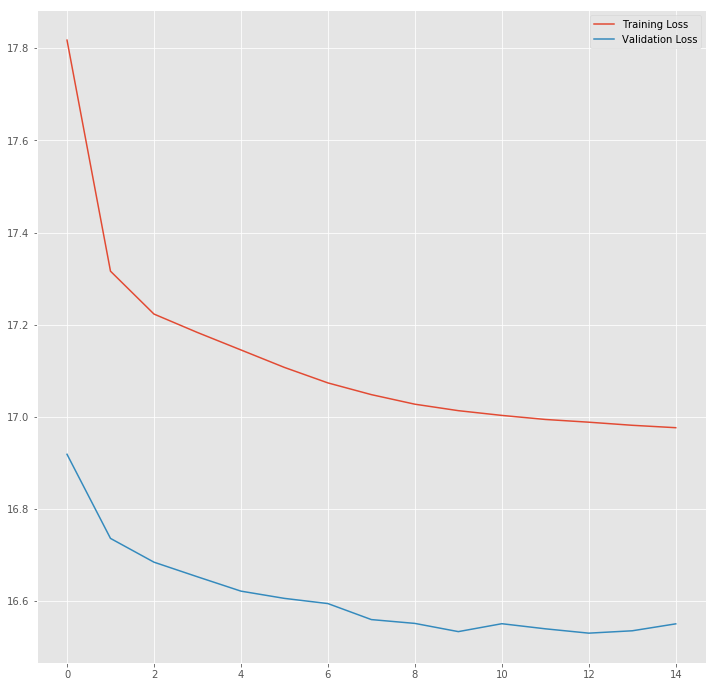

In [23]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

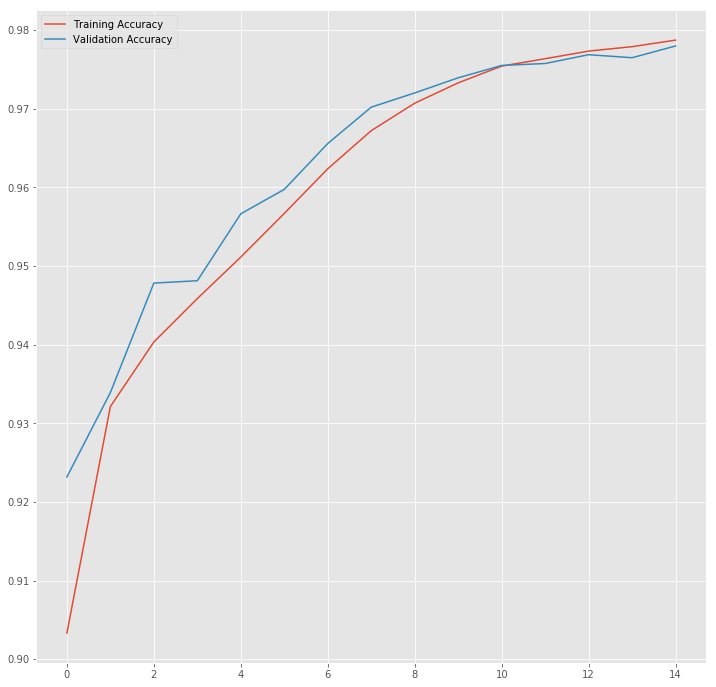

In [24]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["viterbi_acc"], label='Training Accuracy')
plt.plot(hist["val_viterbi_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import classification_report

predicted = model.predict(X_te)

true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    word.append(X_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

wd = [list(map(lambda x: idx2word[x], y)) for y in word]
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

print wd[2]
print predicted_val[2]
print true[2]


print p[2]
print t[2]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
print "\n"
print report

['B', 'Number', 'of', 'eQTLs', 'generated', 'by', 'the', '4613', 'genes', 'significantly', 'correlated', 'with', 'gonadal', 'fat', 'mass', '.', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
[  0   0   0   0 245   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
[0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
['O', 'O', 'O', 'O', 'GO:0032502', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
i = 300
pd = model.predict(np.array([X_te[i]]))
pd = np.argmax(pd, axis=-1)
true = np.argmax(y_te[i], -1)

print X_te[i], pd, true
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")

for w, t1, pred in zip(X_te[i], true, pd[0]):
    if w != 0:
#         print t1, pred
        print("{:15}: {:5} {}".format(words[w-1], idx2tag[t1], idx2tag[pred]))

[13356  9683  5249 12589 11620 15487  2001 17779   160 10573 16129  4111
 13524  3133 14114  2194  3800  9683 13943 15487  5249  3545  6905 12778
  9779 16925  6142  5249  2618  9779 15484  5249  8993 17036   593 11645
 15002  1384  4829  5249 12589  8819  7155   903 17854 13248 10818   703
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0] [[ 0  0  0  0  0  0  0  0  0  0 87  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]] [  0   0   0   0   0   0   0   0   0   0 326   0   0   0   0   0   0   0
  12   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 143   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
W

In [27]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [28]:
df = df[df['Word'] != 'O']

In [29]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print "\n"
print report



                        precision    recall  f1-score   support

            GO:0000003       0.61      0.42      0.50       125
            GO:0000075       0.82      1.00      0.90         9
            GO:0000237       0.00      0.00      0.00         2
            GO:0000238       0.00      0.00      0.00         3
            GO:0000239       1.00      0.90      0.95        21
            GO:0000240       0.44      0.92      0.60        13
            GO:0000267       0.00      0.00      0.00         6
            GO:0000502       0.00      0.00      0.00         1
            GO:0000718       0.00      0.00      0.00         1
            GO:0000732       0.00      0.00      0.00        17
            GO:0000775       0.00      0.00      0.00         3
            GO:0000785       0.89      1.00      0.94        24
            GO:0000786       0.00      0.00      0.00         3
            GO:0000791       0.00      0.00      0.00         1
            GO:0000792       0.92    

In [30]:
df.to_csv('../data/results/GO_merged_RNN_Based.tsv', sep='\t')

In [31]:
%run ./accuracy/src/computeSim.py ../data/results/GO_merged_RNN_Based.tsv ../data/validation_data/GO_AllSubsumers.tsv

Mean semantic similarity:  0.752
